# Prelims

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

import textwrap

In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'
CSV = PATH/'words.csv'

# !ls {PATH}

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Helpers

In [5]:
def nonzero(pred):
    ints = to_np(pred).astype(int)
    return ints[np.nonzero(ints)]

def char_label_text(pred, chunk=70):
    st = ''.join([itos[i] for i in nonzero(pred)])
    return '\n'.join(textwrap.wrap(st, chunk))

def char_split_text(pred):
    return [itos[i] for i in nonzero(pred)]

def word_label_text(pred, chunk=70):
    st = ' '.join([w_itos[i] for i in nonzero(pred)])
    return '\n'.join(textwrap.wrap(st, chunk))

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    if title: ax.set_title(title)
    return ax

# Data

## 3x1

In [7]:
fname = 'synth_words_50000.csv' if device.type == 'cuda' else 'synth_words.csv'
CSV = PATH/fname
FOLDER = 'synth_words'

csv = pd.read_csv(CSV)
len(csv)

50000

In [8]:
sz,bs = 128,100 #(64,120) if device.type == 'cpu' else (128,100)
seq_len = 45
stats = (np.array([0.90382, 0.90382, 0.90382]), np.array([0.19798, 0.19798, 0.19798]))  # inception_stats

## 3x2

In [7]:
fname = 'multi_synth_words_50000.csv' if device.type == 'cuda' else 'multi_synth_words.csv'
CSV = PATH/fname
FOLDER = 'multi_synth_words'

csv = pd.read_csv(CSV)
len(csv)

50000

In [8]:
sz,bs = 256,60
seq_len = 75
stats = (np.array([0.93186, 0.93186, 0.93186]), np.array([0.17579, 0.17579, 0.17579]))

## Large

In [10]:
CSV = PATH/'large_synth_words_50000.csv'
FOLDER = 'large_synth_words'

csv = pd.read_csv(CSV)
len(csv)

50000

In [11]:
sz,bs = 512,30  #400,45
seq_len = 250
stats = (np.array([0.93186, 0.93186, 0.93186]), np.array([0.17579, 0.17579, 0.17579]))

## Paragraphs

In [7]:
CSV = PATH/'paragraph_chars.csv'
FOLDER = 'paragraphs'

csv = pd.read_csv(CSV)
len(csv)

1539

In [8]:
sz,bs = 512,20  #1024,5  #   #~2000x1000 full size
seq_len = 500   #~400 chars/paragraph - max: 705
stats = (np.array([0.94161, 0.94161, 0.94161]), np.array([0.12835, 0.12835, 0.12835]))

## Words

In [32]:
w_itos = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))

In [41]:
name = CSV.stem[:-1] + '_ids' + CSV.suffix    # 'synth_words.csv' => 'synth_word_ids.csv'
W_CSV = PATH/name

# W_CSV = PATH/'multi_synth_word_ids.csv'
# FOLDER = 'multi_synth_words'

In [42]:
w_csv = pd.read_csv(W_CSV)
len(w_csv)

10000

## ModelData

In [9]:
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

val_idxs = np.array(csv.sample(frac=0.15, random_state=42).index)

f = resnet34

In [10]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]
# tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, FOLDER, CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [11]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

### Verify Data

In [12]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.trn_dl))
imgs = denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


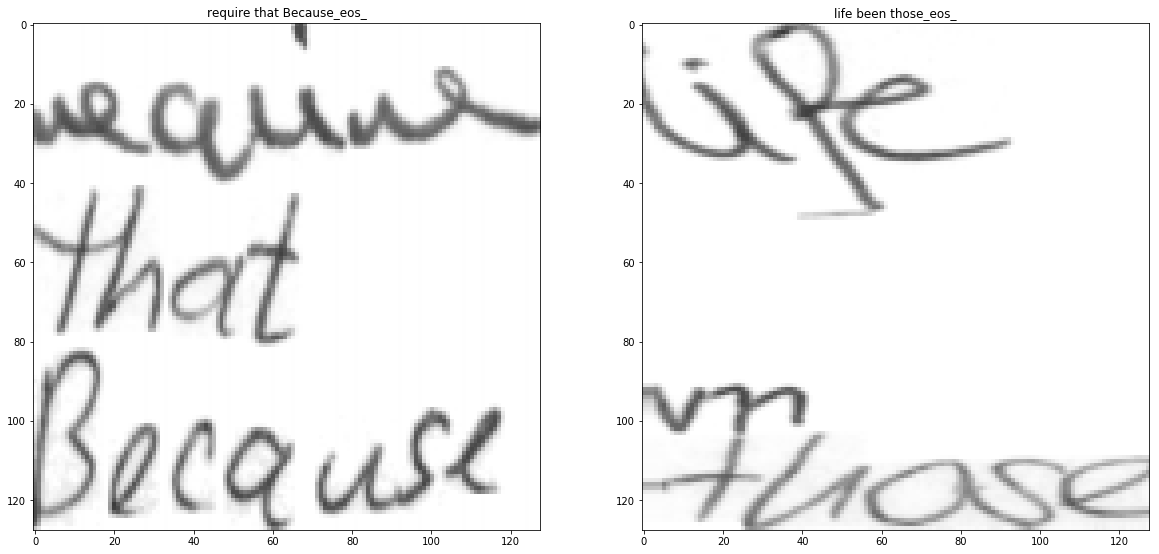

In [13]:
fig, axes = plt.subplots(1,2, gridspec_kw={'hspace': 0.3}, figsize=(20, 10))
for i,ax in enumerate(axes.flat):
    t = char_label_text(y[i])
    ax=show_img(imgs[i], ax=ax, title=t)

## Combine word/char datasets

In [14]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [15]:
w_data = ImageClassifierData.from_csv(PATH, FOLDER, W_CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)
w_data.aug_dl.pre_pad=False
w_data.trn_dl.pre_pad=False
w_data.val_dl.pre_pad=False

NameError: name 'W_CSV' is not defined

In [ ]:
trn_ds = ConcatLblDataset(data.trn_ds, w_data.trn_y)
val_ds = ConcatLblDataset(data.val_ds, w_data.val_y)
data.trn_dl.dataset = trn_ds
data.val_dl.dataset = val_ds

### Verify multi dataset

In [ ]:
denorm = data.trn_ds.ds.denorm   # need the extra .ds when using ConcatLblDataset
_,(y0,y1) = next(iter(data.trn_dl))

In [ ]:
chars = [itos[int(w)] for w in y0[-2]]
''.join(chars)

In [ ]:
words = [w_itos[int(c)] for c in y1[-2]]
' '.join(words)

# Loss and Metrics

In [14]:
def loss_prep(input, target):
    "equalize input/target sl; combine bs/sl dimensions"
    bs,tsl = target.shape
    _ ,sl,vocab = input.shape
        
    # F.pad( front,back for dimensions: 1,0,2 )
    if sl>tsl: target = F.pad(target, (0,sl-tsl))
    if tsl>sl: target = target[:,:sl]
#     if tsl>sl: input = F.pad(input, (0,0,0,0,0,tsl-sl))
        
    targ = target.contiguous().view(-1).long()
    pred = input.contiguous().view(-1, vocab)
    return pred, targ

In [15]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        
    def forward(self, pred, target):
        pred,targ = loss_prep(pred, target)
        pred = F.log_softmax(pred, dim=-1)  # need this for KLDivLoss
        true_dist = pred.data.clone()
        true_dist.fill_(self.smoothing / pred.size(1))                  # fill with 0.0012
        true_dist.scatter_(1, targ.data.unsqueeze(1), self.confidence)  # [0.0012, 0.0012, 0.90, 0.0012]
        return F.kl_div(pred, true_dist, reduction='sum')/bs

In [16]:
def XE_loss(input, target):    # takes logits
    pred,targ = loss_prep(input, target)
    return F.cross_entropy(pred, targ, reduction='sum')/bs

In [17]:
def perplexity(input, target):
    pred,targ = loss_prep(input, target)
    return np.exp(F.cross_entropy(pred, targ))

In [18]:
def Focal_loss(input, target):
    pred,targ = loss_prep(input, target)
    wgt = get_weight(pred, targ)
    wgt = wgt.mean(0).detach()   # This seems naively logical but probably a terrible idea... 
    return F.cross_entropy(pred, targ, weight=wgt, reduction='sum')/bs
    
def get_weight(p,t):
    t = one_hot_encode(p,t)
    alpha,gamma = 0.25,1
    p = p.sigmoid()
    pt = p*t + (1-p)*(1-t)
    w = alpha*t + (1-alpha)*(1-t)
    return w * (1-pt).pow(gamma)

def one_hot_encode(p,t):
    hot = torch.zeros_like(p)
    return hot.scatter_(1, t.data.unsqueeze(1), 1)

In [19]:
import Levenshtein as Lev

# pulled from Sean Nareen's deepspeech decoder module
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/decoder.py

def cer(t, p):
    """
    Computes the Character Error Rate, defined as the edit distance.
    Arguments:
        t (string): target space-separated sentence
        p (string): prediction space-separated sentence
    """
    t, p, = t.replace(' ', ''), p.replace(' ', '')
    return Lev.distance(t, p)/len(t)

def wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein package only accepts strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))/len(w1)

In [20]:
def char_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([bs, sl, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = char_label_text(res[i])
        t = char_label_text(targs[i])
        error += cer(t,p)
    return error/bs

def word_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([bs, sl, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = word_label_text(res[i])
        t = word_label_text(targs[i])
        error += wer(t,p)
    return error/bs

# Transformer Architecture

In [21]:
# similar to batchnorm but on a layer level
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [22]:
class SublayerConnection(nn.Module):
    "A residual connection followed by a layer norm.  Note: (for code simplicity) norm is first."
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [23]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [24]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, src):
        for layer in self.layers:
            x = layer(x, src)
        return self.norm(x)

In [25]:
class EncoderLayer(nn.Module):
    "Encoder: src-attn and feed forward"
    def __init__(self, size, src_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.size = size
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)

    def forward(self, x, src):
        x = self.sublayer[0](x, lambda x: self.src_attn(x, src, src))
        return self.sublayer[1](x, self.feed_forward)

In [26]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [27]:
class DecoderLayer(nn.Module):
    "Decoder: self-attn and feed forward"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
 
    def forward(self, x, mask=None):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [28]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    depth = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(depth)  #(bs, sl, hw)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)    
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn   #(bs, sl, d_model)

In [29]:
class SingleHeadedAttention(nn.Module):
    def __init__(self, d_model, dropout=0.2):
        super(SingleHeadedAttention, self).__init__()
        self.linears = clones(nn.Linear(d_model, d_model), 3) #4
        self.attn = None
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, mask=None):        
        query, key, value = [l(x) for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        return x #self.linears[-1](x)

In [30]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, dropout=0.2):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_model*4)
        self.w_2 = nn.Linear(d_model*4, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [31]:
class PositionalEncoding(nn.Module):
    "Modified the PE function for 2 dimensions"
    def __init__(self, d_model, dims=1, dropout=0.2, max_len=2000):
        super(PositionalEncoding, self).__init__()
        assert dims<=2, "More than 2 dimensional PE is not implemented"
        
        self.dropout = nn.Dropout(p=dropout)
        self.dims = dims
        
        channels = d_model//dims
        pe = torch.zeros(max_len, channels)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        log_increment = math.log(1e4) / channels
        div_term = torch.exp(torch.arange(0.0, channels, 2) * -log_increment)  
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe.unsqueeze_(0)
        
        if dims==2:
            w_pe = F.pad(pe, (0,channels)).unsqueeze(2)
            h_pe = F.pad(pe, (channels,0)).unsqueeze(1)
            pe = w_pe + h_pe

        self.register_buffer('pe', pe)    #(1,max_len,max_len,d_model)
        
    def forward(self, x):
        # 1d: ([bs, sl, d_model])     2d: ([bs, h, w, d_model])
        if self.dims == 1:
            x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        else:
            x = x + Variable(self.pe[:, :x.size(1), :x.size(2)], requires_grad=False)
            x = x.flatten(1,2).contiguous()
        return self.dropout(x)

In [34]:
class Mixer(nn.Module):
    def __init__(self, d_model, drop):
        super(Mixer, self).__init__()
        
        self.linears = clones(nn.Linear(d_model, d_model), 2)
        self.out = nn.Linear(d_model*2, d_model)
        self.drop = nn.Dropout(drop)
        self.norm = LayerNorm(d_model)
        
    def forward(self, enc, dec):
        x = torch.cat([self.linears[0](enc), self.linears[1](dec)], dim=-1)
        x = self.out(self.drop(x))
        return self.norm(x)

In [33]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, mixer, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.mixer = mixer
        self.tgt_embed = tgt_embed
        self.generator = generator
        self.embed = None
        
    def forward(self, src, tgt, tgt_mask=None):
        enc = self.encode(tgt, src)
        dec = self.decode(tgt_mask)
        return self.mixer(enc,dec)
#         return self.decode(self.encode(src), tgt, tgt_mask)
    
    def encode(self, tgt, src):
        self.embed = self.tgt_embed(tgt)
        return self.encoder(self.embed, src)
    
    def decode(self, tgt_mask=None):
        return self.decoder(self.embed, tgt_mask)        
        
    def generate(self, outs):
        return self.generator(outs)

# Stepper

In [35]:
def subsequent_mask(size):
    attn_shape = torch.ones((size,size), dtype=torch.uint8, device=device)
    mask = torch.tril(attn_shape).unsqueeze(0)
    return mask

def make_tgt_mask(tgt, pad=0):
    "Create a mask to hide padding and future words."
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return tgt_mask

In [36]:
def rshift(tgt, token=1):
    "Shift y to the right by prepending token"
    return torch.cat((torch.ones((tgt.size(0),token), device=device), tgt[:,:-1]), dim=-1)

In [37]:
class TfmrStepper(Stepper):
    def step(self, xs, y, epoch):
#         self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        xtra = []
    
        # without BOS token:
        shifted_y = rshift(y).long()
        tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)
        output = self.m(*xs, shifted_y, tgt_mask)
        
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()        
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm_(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.item()
    
    def evaluate(self, xs, y):
        shifted_y = rshift(y).long()
        tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)
        preds = self.m(*xs, shifted_y, tgt_mask)
        if isinstance(preds,tuple): preds=preds[0]
        return preds, self.crit(preds, y)

# Spatial Transformer

In [36]:
class SpatialTransformer(nn.Module):
    def __init__(self, n_in, n_out, k1, k2, h, w=None):
        super(SpatialTransformer, self).__init__()
        if not w: w = h
        
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(n_in, n_out, kernel_size=k1, padding=k1//2),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(n_out, n_out, kernel_size=k2, padding=k2//2),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(n_out * w * h, n_out),
            nn.ReLU(True),
            nn.Linear(n_out, 6)
        )
        # Attention: only need 3 outputs
        # [[s,0,tx],
        #  [0,s,ty]]

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def forward(self, x):
        xs = self.localization(x)
        xs = xs.flatten(1,-1)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

# Img2seq Arch

In [38]:
class ResnetBase(nn.Module):
    def __init__(self, em_sz, d_model):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[em_sz]
        net = f(True)
        modules = list(net.children())[:s]
        self.base = nn.Sequential(*modules)
        
        self.adaptor = nn.Sequential(
            nn.Conv2d(em_sz, d_model, 1),
            nn.BatchNorm2d(d_model)
        )
#         self.stn = SpatialTransformer(3,32,7,5,32)
        
    def forward(self, x):
#         x = self.stn(x)
        x = self.base(x)
        x = self.adaptor(x).permute(0,2,3,1)         # bs,h,w,d_model
        return x.flatten(1,2).contiguous()

In [65]:
def make_full_model(vocab, d_model=512, N=4, drops={'attn':0.2, 'ff':0.2, 'pos':0.2, 'layer':0.2}):
    c = copy.deepcopy
    attn = SingleHeadedAttention(d_model)
    ff = PositionwiseFeedForward(d_model, drops['ff'])

    model = EncoderDecoder(
#         PositionalEncoding(d_model, 2, drops['pos']),
        Encoder(EncoderLayer(d_model, c(attn), c(ff), drops['layer']), N),
        Decoder(DecoderLayer(d_model, c(attn), c(ff), drops['layer']), N),
        Mixer(d_model, drops['layer']),
        nn.Sequential(
            nn.Embedding(vocab, d_model),
            PositionalEncoding(d_model, 1, drops['pos'])
        ),
        nn.Linear(d_model, vocab)
    )
        
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
                    
    return model

In [40]:
class Img2Seq(nn.Module):
    def __init__(self, img_encoder, transformer):
        super(Img2Seq, self).__init__()
        self.img_enc = img_encoder
        self.transformer = transformer
        
    def forward(self, src, tgt=None, tgt_mask=None):
        feats = self.img_enc(src)                            # ([bs, h*w, d_model])
        dec_outs = self.transformer(feats, tgt, tgt_mask)    # ([bs, sl, d_model])
        out = self.transformer.generate(dec_outs)            # ([bs, sl, vocab])
        return out

    def greedy_decode(self, src, seq_len):
        with torch.no_grad():
            feats = self.img_enc(src)
            bs = src.size(0)
            tgt = torch.ones((bs,1), dtype=torch.long, device=device)

            res = []                
            for i in tqdm(range(seq_len)):
                dec_outs = self.transformer(feats, Variable(tgt))
                prob = self.transformer.generate(dec_outs[:,-1])
                res.append(prob)
                pred = torch.argmax(prob, dim=-1, keepdim=True)
                if (pred==0).all(): break
                tgt = torch.cat([tgt,pred], dim=-1)
            out = torch.stack(res).transpose(1,0).contiguous()
            return out      

In [66]:
d_model = 512
em_sz = 256
img_encoder = ResnetBase(em_sz, d_model)
transformer = make_full_model(len(itos), d_model)
net = Img2Seq(img_encoder, transformer)

opt_fn = partial(optim.Adam, betas=(0.7, 0.99)) #, lr=0, betas=(0.9, 0.98), eps=1e-9)
# partial: way to always call a function with a given set of arguments or keywords

learn = RNN_Learner(data, SingleModel(to_gpu(net)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = LabelSmoothing(smoothing=0.1)   #XE_loss
learn.metrics = [char_error_rate]

# Train

### load state dict for changes

In [55]:
#LM
LM_PATH = Path('data/wikitext/wikitext-2-raw')
sd = torch.load(LM_PATH/'models'/'LM.h5', map_location=lambda storage, loc: storage)

In [59]:
sd.keys()

odict_keys(['transformer.decoder.layers.0.self_attn.linears.0.weight', 'transformer.decoder.layers.0.self_attn.linears.0.bias', 'transformer.decoder.layers.0.self_attn.linears.1.weight', 'transformer.decoder.layers.0.self_attn.linears.1.bias', 'transformer.decoder.layers.0.self_attn.linears.2.weight', 'transformer.decoder.layers.0.self_attn.linears.2.bias', 'transformer.decoder.layers.0.feed_forward.w_1.weight', 'transformer.decoder.layers.0.feed_forward.w_1.bias', 'transformer.decoder.layers.0.feed_forward.w_2.weight', 'transformer.decoder.layers.0.feed_forward.w_2.bias', 'transformer.decoder.layers.0.sublayer.0.norm.a_2', 'transformer.decoder.layers.0.sublayer.0.norm.b_2', 'transformer.decoder.layers.0.sublayer.1.norm.a_2', 'transformer.decoder.layers.0.sublayer.1.norm.b_2', 'transformer.decoder.layers.1.self_attn.linears.0.weight', 'transformer.decoder.layers.1.self_attn.linears.0.bias', 'transformer.decoder.layers.1.self_attn.linears.1.weight', 'transformer.decoder.layers.1.self_at

In [ ]:
sd = torch.load(PATH/'models'/'tfmr_paragraph.h5', map_location=lambda storage, loc: storage)

In [78]:
sd.pop('img_enc.linear.bias')   # need to remove mismatched linear weight

tensor([-0.0339,  0.0369,  0.0429,  0.0000, -0.0198, -0.0293,  0.0288,  0.0490,
        -0.0303, -0.0415,  0.0184,  0.0527,  0.0322, -0.0581, -0.0493,  0.0425,
        -0.0194, -0.0407,  0.0243, -0.0465, -0.0298,  0.0616,  0.0551,  0.0073,
         0.0286, -0.0051, -0.0411,  0.0063, -0.0160,  0.0192,  0.0349,  0.0445,
         0.0560,  0.0577,  0.0356, -0.0498,  0.0571,  0.0054,  0.0317, -0.0209,
        -0.0259,  0.0265, -0.0152,  0.0359, -0.0421,  0.0623,  0.0123, -0.0527,
         0.0392, -0.0311, -0.0215, -0.0348, -0.0314, -0.0439,  0.0543,  0.0438,
         0.0430,  0.0557, -0.0076, -0.0606,  0.0370, -0.0542,  0.0028, -0.0079,
         0.0170, -0.0332, -0.0427, -0.0378, -0.0237,  0.0175, -0.0618,  0.0533,
        -0.0602,  0.0301,  0.0564, -0.0046,  0.0106, -0.0213, -0.0015, -0.0398,
        -0.0157,  0.0106,  0.0361,  0.0315,  0.0588,  0.0416, -0.0026,  0.0048,
        -0.0007, -0.0588, -0.0167,  0.0540,  0.0391, -0.0512,  0.0549,  0.0088,
         0.0049,  0.0618,  0.0445, -0.02

In [67]:
learn.model.load_state_dict(sd, strict=False)

### load model

In [39]:
learn.load('tfmr_full_lg')

## LR find

 54%|█████▎    | 381/709 [05:26<04:41,  1.17it/s, loss=111] 

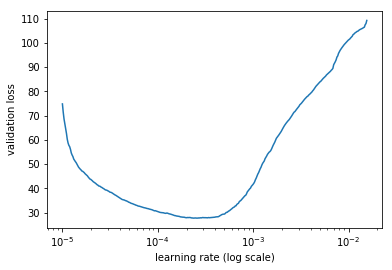

In [42]:
learn.lr_find(stepper=TfmrStepper)
learn.sched.plot(n_skip=0, n_skip_end=2)

## Experimentation

In [41]:
#gpu
lr=1e-4
learn.fit(lr, 5, cycle_len=1, stepper=TfmrStepper, use_clr=(20,5))
# 3x1: XE/bs, kaiming_normal, no pos_enc, emb/out weight tying, no encoder, 2 layers, 256/256, single attn
# 52.199187  50.1736    0.730092    lr:1e-4
# 17.318725  13.803769  0.205331    2nd run, lr: 1e-3
# 11.96539   9.991971   0.151522    3rd run, lr: 1e-4     **tfmr

# Loss fns
# 43.177135  41.245482  1.185836    LabelSmoothing (KL/bs)
# 4215.8745  4012.3099  0.957795    LabelSmoothing (KL)
# 45.200728  43.662235  0.753881    LabelSmoothing (KL/bs w/out padding logic)  perplexity < BLEU/acc
# 5340.5770  5129.8346  0.738853    XE                    --- scaling by BS not a factor
# 52.199187  50.1736    0.730092    XE/bs  **

# Initialization/Activation
# 52.199187  50.1736    0.730092    kaiming_normal  (ff activation: leaky_relu)
# 52.987157  50.976083  0.758013    kaiming_uniform
# 49.553779  47.270616  0.702353    xavier_normal
# 49.380884  47.345175  0.673508    xavier_uniform  (ff activation: leaky_relu)   **
# 49.849071  47.369221  0.708807    xavier_uniform  (ff activation: relu)

# Positional Encoding
# 35.426869  30.449724  0.423573    target only; no embed/out weight tying   **
# 35.390268  31.216677  0.45097     "" ; w/ scaling factor [* math.sqrt(d_model)]
# 45.596748  42.213515  0.572662    target only; w/ embed/out weight tying

# Encoder
# 34.46771   29.207974  0.408425    **

# Attention
# 32.087941  26.431674  0.362717    SingleHead - linear layers for (q,k,v)
# 37.739475  32.962685  0.454753    MultiHead (8)
# 36.09057   31.346036  0.432342    MultiHead (4)
# 31.069687  26.00539   0.360032    MultiHead (1)     **

# N layers (6)
# 51.119606  48.809905  0.645302

# d_model = 512
# 21.032752  17.234559  0.230763    ~11:35  **

# em_sz
# 27.589121  22.698359  0.307399    128  ~14:09
# 28.320952  24.183105  0.338207    512  ~11:31

# include layer_norm in encoder/decoder
# 24.035412  19.824303  0.270881   modified: self.norm(x + self.dropout(sublayer(x)))
# 20.347157  17.23408   0.228328   original:  x + self.dropout(sublayer(self.norm(x)))   **tfmr_experiment
# 10.732795  9.875141   0.12633    2nd run

epoch      trn_loss   val_loss   char_error_rate             
    0      97.113231  96.433993  0.785958  
    1      92.932865  91.588046  0.763503                    
    2      89.786796  88.617287  0.748317                    
    3      87.713446  86.262771  0.73032                     
    4      85.60537   84.471601  0.718985                    



[84.47160137939453, 0.7189845258168942]

In [52]:
learn.save('tfmr_experiment')

## Initial size

In [58]:
learn.load('tfmr_full_lg')

In [59]:
lr=1e-4
learn.fit(lr, 10, cycle_len=1, stepper=TfmrStepper, use_clr=(20,10))
# 3x1, sz: 128, bs: 100
# 20.347157  17.23408   0.228328
# 10.732795  9.875141   0.12633     2nd run

# 6.753466   6.750452   0.085309    Full Transformer (4N/4h), 10cycles(20,10)   ~33m   'tfmr_full_3x1'
# 7.0736     6.798651   0.085855    "", single attn, 10cycles(20,10)            ~38m

# 3x2; sz: 256, bs: 60
# 14.65408   13.10881   0.090017    preload tfmr_3x1_256
# 4.464029   5.072127   0.037011    Full Transformer (4N/0h), 10cycles(20,10)   ~1h 46m

# lg; sz: 400, bs: 30
# 98.491235  89.396089  0.123849    preload tfmr_3x2      'tfmr_lg'
# 101.903571 88.239827  0.122516    -same as above-       'tfmr_lg2'
# bs: 45
# 161.90945  169.713365 0.207615    dropout:0.5    'tfmr_lg_tmp'
# 29.706235  25.84234   0.039261    Full Transformer (4N/0h), 10cycles(20,10)   ~3h 47m

# paragraph; sz:512, bs:30
# 289.464371 202.553455 0.175994     preload tfmr_lg2, 4 cycles
# 178.432805 145.702918 0.128241     2nd run, 5 cycles
# 144.489454 130.875442 0.116076     3rd run              'tfmr_paragraph'
# bs: 20
# 66.923881  70.373825  0.069164     Full Transformer (4N/0h), 10cycles(20,10)   ~23m     'tfmr_full_paragraph'
# 81.810724  78.974658  0.078329     "", reversed src_attn/self_attn

epoch      trn_loss   val_loss   char_error_rate           
    0      348.027862 248.023407 0.245555  
    1      265.82698  172.056555 0.171563                  
    2      213.187992 136.243882 0.138434                  
    3      175.590073 116.484703 0.118255                  
    4      143.236334 101.962209 0.1025                    
    5      126.411766 93.444394  0.093553                  
    6      109.22227  90.448982  0.089549                  
    7      96.852387  84.184608  0.083422                  
    8      89.701086  79.604352  0.07891                   
    9      81.810724  78.974658  0.078329                  


[78.9746576944987, 0.07832948576963876]

In [39]:
learn.save('tfmr_full_paragraph')

## Increase size

In [43]:
sz,bs = 512,30

In [67]:
learn.set_data(data)

In [ ]:
lr=1e-4
learn.fit(lr, 5, cycle_len=1, stepper=TfmrStepper, use_clr=(20,5))
# 3x1; sz: 256, bs: 60
# 8.169301   7.199782   0.087933    fresh start
# 4.305115   4.585243   0.054132    2nd run (increase dropout 0.2)     'tfmr_3x1_256'
# 3.6729     3.756866   0.047393    resize from 128

# 2.450041   2.695453   0.032867    Full Transformer (4N/4h)   ~43m 48s       'tfmr_full_3x1'
# 2.577439   2.748884   0.033926    Full Transformer (4N/0h)   ~45 54s        'tfmr_full_3x1_single_attn'

# 3x2; sz: 400, bs: ?
# 5.701717   5.83973    0.039572    resize from 256 (increase dropout 0.3)     'tfmr_3x2'
# 2.24673    2.478204   0.017335    Full Transformer (4N/0h)   ~2h 31m     'tfmr_full_3x2'

# lg; sz: 512, bs: 30
# 38.786294  45.805161  0.061061    resize from 400  -quit after 3 epochs-
# 8.317326   8.491839   0.010576    Full Transformer (4N/0h)   ~2h 31m     'tfmr_full_lg'

# preload tfmr_lg2; increase dropout to 0.3 in attention and ff; wd; lower lr
# 98.273312  60.214675  0.08372    lr: 1.5e-5, wd: 1e-5, 3 cycles(20,4)                    'tfmr_lg_wd'
# 81.961758  53.715966  0.075622   lr: 2e-5, no wd, 4 cycles(20,5)  -quit after 2 epochs-  'tfmr_lg_wd_tmp'
# 45.696747  37.355512  0.053213   "", {drops}, preloaded tfmr_lg_wd_tmp                   'tfmr_lg2'

# paragraph; sz:800, bs:10
# 100.395217 86.058532  0.074781     resize from 512
# 78.234521  81.089716  0.067993     2nd run           'tfmr_paragraph_800'

# paragraph; sz: 1024, bs:5
# 55.707705  56.274219  0.05457     Full Transformer (4N/0h), 10cycles(20,10)   ~23m   'tfmr_full_paragraph2'

epoch      trn_loss   val_loss   char_error_rate           
    0      105.453996 77.089955  0.077484  
    1      83.551379  68.040677  0.067502                   
 92%|█████████▏| 240/262 [04:53<00:26,  1.22s/it, loss=73.2]

In [41]:
learn.save('tfmr_full_paragraph2')

# Experiment

In [68]:
#gpu
lr=1e-4
learn.fit(lr, 10, cycle_len=1, stepper=TfmrStepper, use_clr=(20,10))
# 3x1: XE/bs, kaiming_normal, no pos_enc, emb/out weight tying, no encoder, 2 layers, 256/256, single attn
# 52.199187  50.1736    0.730092    lr:1e-4
# 17.318725  13.803769  0.205331    2nd run, lr: 1e-3
# 11.96539   9.991971   0.151522    3rd run, lr: 1e-4     **tfmr

# Loss fns
# 43.177135  41.245482  1.185836    LabelSmoothing (KL/bs)
# 4215.8745  4012.3099  0.957795    LabelSmoothing (KL)
# 45.200728  43.662235  0.753881    LabelSmoothing (KL/bs w/out padding logic)  perplexity < BLEU/acc
# 5340.5770  5129.8346  0.738853    XE                    --- scaling by BS not a factor
# 52.199187  50.1736    0.730092    XE/bs  **

# Initialization/Activation
# 52.199187  50.1736    0.730092    kaiming_normal  (ff activation: leaky_relu)
# 52.987157  50.976083  0.758013    kaiming_uniform
# 49.553779  47.270616  0.702353    xavier_normal
# 49.380884  47.345175  0.673508    xavier_uniform  (ff activation: leaky_relu)   **
# 49.849071  47.369221  0.708807    xavier_uniform  (ff activation: relu)

# Positional Encoding
# 35.426869  30.449724  0.423573    target only; no embed/out weight tying   **
# 35.390268  31.216677  0.45097     "" ; w/ scaling factor [* math.sqrt(d_model)]
# 45.596748  42.213515  0.572662    target only; w/ embed/out weight tying

# Encoder
# 34.46771   29.207974  0.408425    **

# Attention
# 32.087941  26.431674  0.362717    SingleHead - linear layers for (q,k,v)
# 37.739475  32.962685  0.454753    MultiHead (8)
# 36.09057   31.346036  0.432342    MultiHead (4)
# 31.069687  26.00539   0.360032    MultiHead (1)     **

# N layers (6)
# 51.119606  48.809905  0.645302

# d_model = 512
# 21.032752  17.234559  0.230763    ~11:35  **

# em_sz
# 27.589121  22.698359  0.307399    128  ~14:09
# 28.320952  24.183105  0.338207    512  ~11:31

# include layer_norm in encoder/decoder
# 24.035412  19.824303  0.270881   modified: self.norm(x + self.dropout(sublayer(x)))
# 20.347157  17.23408   0.228328   original:  x + self.dropout(sublayer(self.norm(x)))   **tfmr_experiment
# 10.732795  9.875141   0.12633    2nd run



# 3x2 attention/pos_enc experiments
# 44.391676  40.633241  0.308526    baseline (src before self attn)    ~1h 7m
# 18.111974  18.16437   0.117756    10 cycles                          ~1h 52m      tmp_base
# 57.85619   51.015644  0.418202    pos_enc2d/no encoder; 256 + conv 1   ~44m       
# 27.356499  24.327117  0.17227     2nd run - attention not working well            tmp_2
# 16.581052  15.659028  0.104724    3rd run                                         tmp_3
# 55.944376  52.067722  0.417235    baseline w/ pos_enc2d; 256 + conv1    ~57m      tmp2


# 3x1, 10 cycles
# 23.452119  20.750421  0.30148     conv, enc: pos2d, out: Linear    ~20m
# 10.747468  11.945359  0.148952    2nd run

# 22.816471  20.652263  0.300892    w/ STN (32/7/5/32/32) before img_encoder
# 24.154148  21.474449  0.314114    w/ STN (32/7/5/64/64) before img_encoder
# 24.315829  21.928237  0.319867    adding bn after conv (no STN)
# 25.852014  23.393568  0.345979    "", w/ STN(em_sz, d_model, 2) after img_encoder
# 22.586863  20.337497  0.294407    "", w/ STN (32/7/5/32/32) before img_encoder     ~21m
# 11.062696  11.752348  0.146163    2nd run

# 17.356167  15.935936  0.223704    linear, enc: None, out: Linear    ~19m
# 15.614188  14.634603  0.205307    conv/bn, enc: None, out: Linear    ~19m   **
# 17.618474  15.867109  0.220721    ""    ~20m
# 8.634967   9.732577   0.13152     2nd run    'tmp'  [src-attn tracks well]

# 17.213856  16.036616  0.228302    conv/bn, enc: None, out: MLP    ~20m
# 17.269863  16.052437  0.224499    conv/bn, enc: Encoder, out: Linear    ~23m
# 17.999301  16.085523  0.223856    conv/bn, enc: pos2d, out: Linear    ~19m
# 19.352792  17.537506  0.249201    conv/bn, STN(32/7/5), enc: pos2d, out: Linear ~21m
# 21.778735  19.844897  0.288944    conv/bn, STN(32/7/5), enc: pos2d, out: MLP    ~22m

# 15.627235  14.005776  0.18804     dec: w/ self-attn + src-attn
# 7.056934   7.818964   0.10034     2nd run    'tmp2'    [loss decrease but src-attn tracks worse]

# 17.841002  16.682544  0.221875    enc: src-attn, dec: self-attn, mixer: +tanh   ~22m
# 6.         8.         0.12        2nd run

# 15.780708  14.452696  0.205315    enc: src-attn, dec: self-attn, mixer: cat/lin   ~20m    'tmp3'

# 7.48091    7.132944   0.092341    "", dec: preloaded LM, "", N:4

epoch      trn_loss   val_loss   char_error_rate            
    0      27.736549  24.729009  0.395144  
    1      21.093219  18.492941  0.293818                   
    2      17.271864  15.182316  0.227709                   
    3      14.445418  12.723701  0.18192                    
    4      12.635744  11.097611  0.153908                   
    5      11.096848  9.915989   0.13298                    
    6      9.8695     9.002588   0.118542                   
    7      8.995641   8.243133   0.108717                   
    8      8.10708    7.636632   0.100124                   
    9      7.48091    7.132944   0.092341                   



[7.132943636576335, 0.09234101977501655]

In [69]:
learn.save('tmp4')

# Test

In [43]:
from scipy.ndimage import gaussian_filter
k=16

def torch_scale_attns(attns):
    bs,sl,hw = attns.shape
    num = int(math.sqrt(hw))   # sz // k
    mod = attns.view(bs,sl,num,num)
    scaled = F.interpolate(mod, size=sz)
    return scaled  #([bs, sl, h, w])

def g_filter(att):
    return gaussian_filter(att, sigma=k)

In [44]:
def self_attn(layer=-1): return learn.model.transformer.decoder.layers[layer].self_attn.attn.data
def source_attn(layer=-1): return learn.model.transformer.encoder.layers[layer].src_attn.attn.data

In [62]:
learn.load('tfmr_full_paragraph')

## Validation Results

In [97]:
x,y = next(iter(data.val_dl))

shifted_y = rshift(y).long()
tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)

learn.model.eval()
preds = learn.model(x, shifted_y, tgt_mask)
res = torch.argmax(preds, dim=-1)

In [98]:
learn.crit(preds, y)
# lg 512: 27.19
# pg 512: 172.8431
# pg 800: 58.760

tensor(11.5952, device='cuda:0', grad_fn=<DivBackward0>)

In [99]:
char_error_rate(preds, y)
# lg 512: 0.047
# pg 512: 0.166
# pg 800: 0.053

0.1467147164544629

### Images

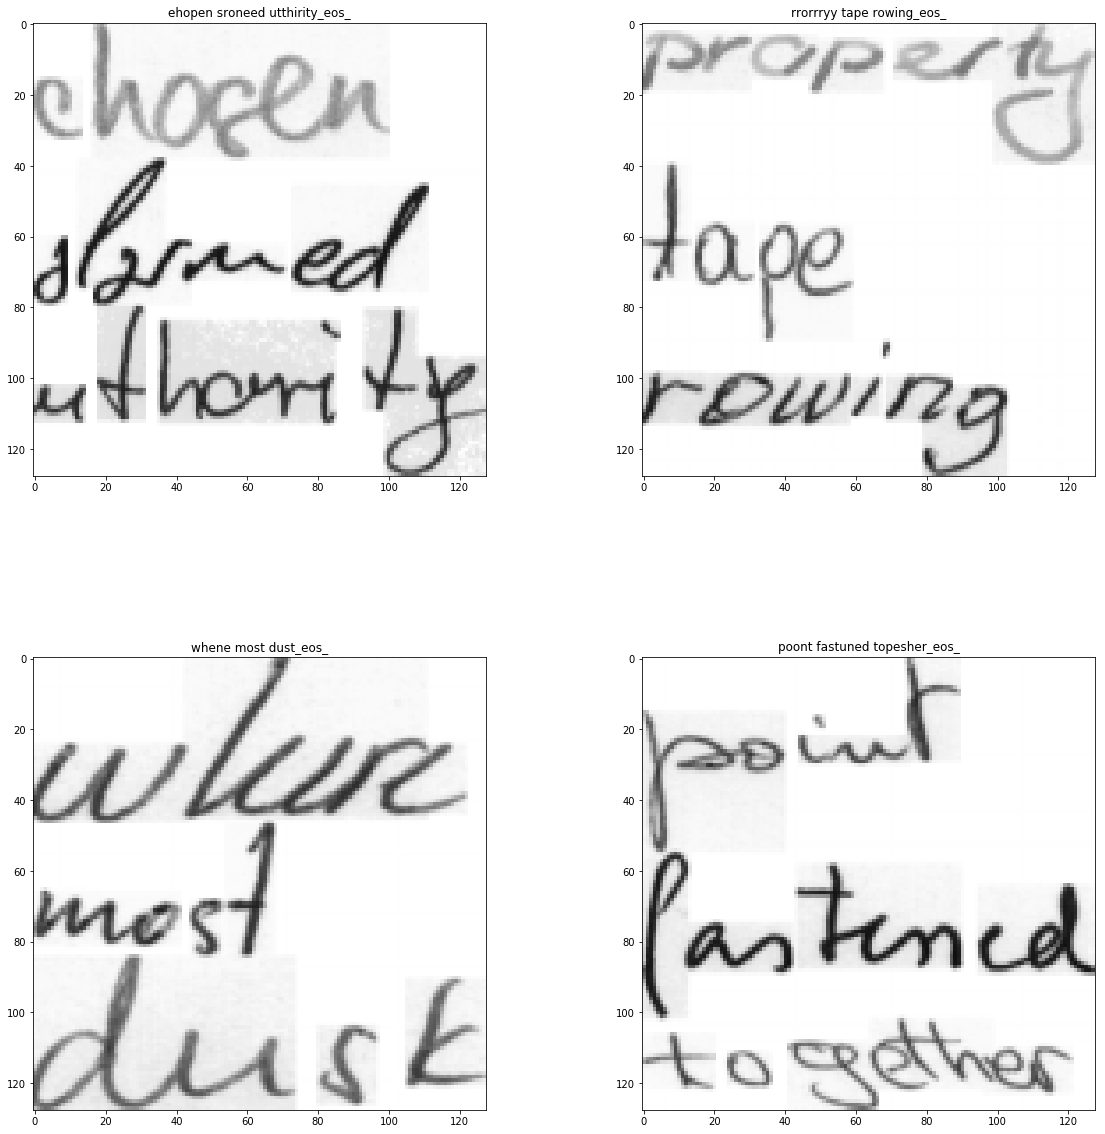

In [52]:
imgs = data.val_ds.denorm(x)

fig, axes = plt.subplots(2,2, gridspec_kw={'hspace': 0.4}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    p = char_label_text(res[i])
    ax=show_img(imgs[i], ax=ax, title=p)
    
# plt.tight_layout(pad=0.1)

### Source Attn

In [102]:
idx = 1
img = imgs[idx]
pred = res[idx]
img_attns = to_np(torch_scale_attns(source_attn())[idx])

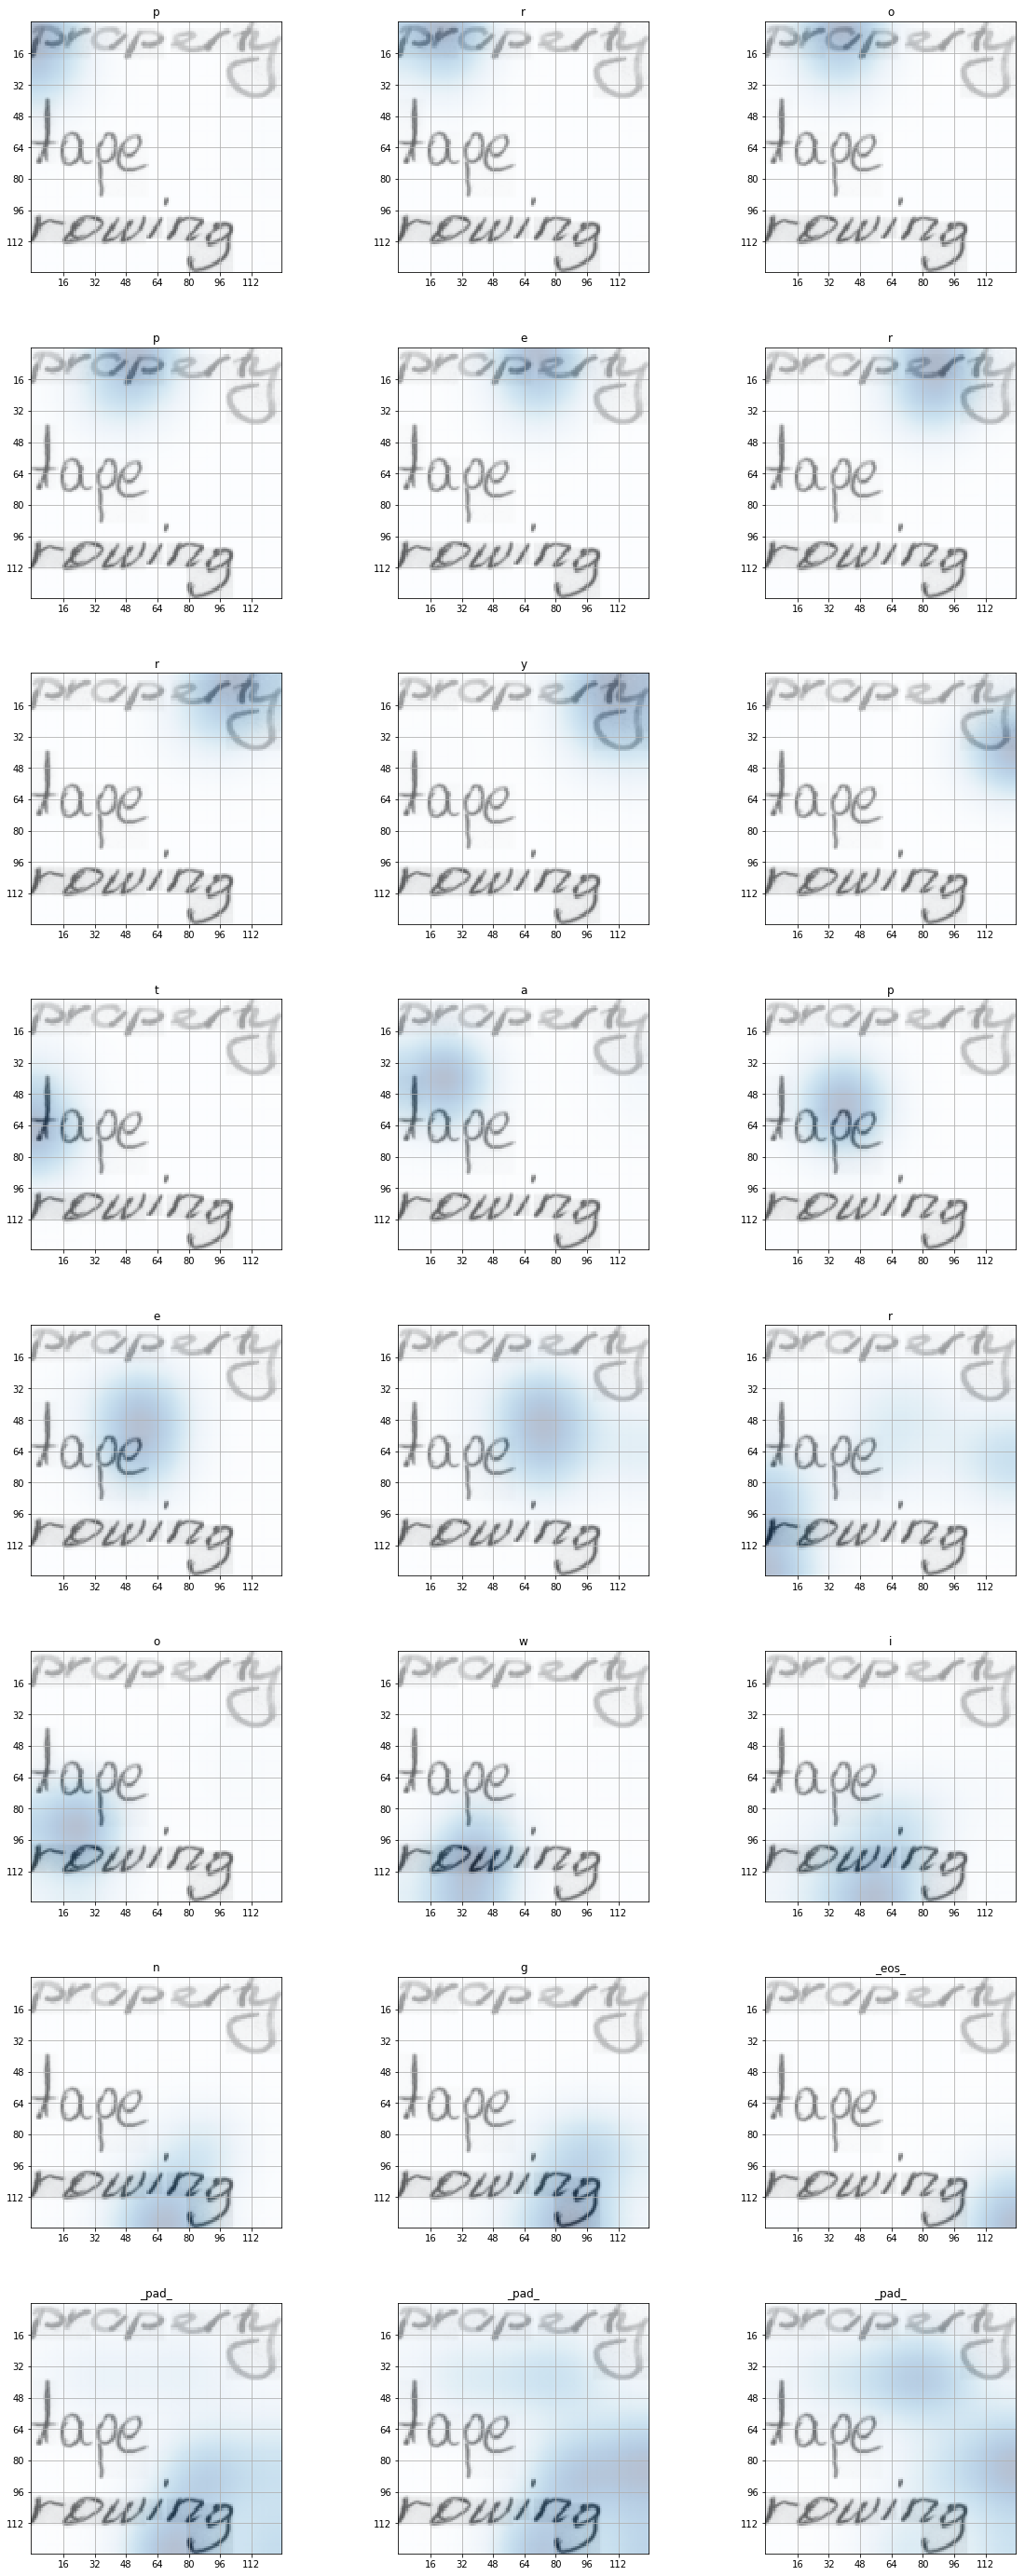

In [103]:
fig, axes = plt.subplots(8,3, gridspec_kw={'hspace': 0.3}, figsize=(20, 50))
for i,ax in enumerate(axes.flat):
    a = g_filter(img_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    
    # Attention
    ticks = np.arange(k, sz, k)
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    ax.set_title(itos[pred[i].item()])

### Layer 2

In [108]:
idx = 1
img = imgs[idx]
pred = res[idx]
img_attns = to_np(torch_scale_attns(source_attn(0))[idx])

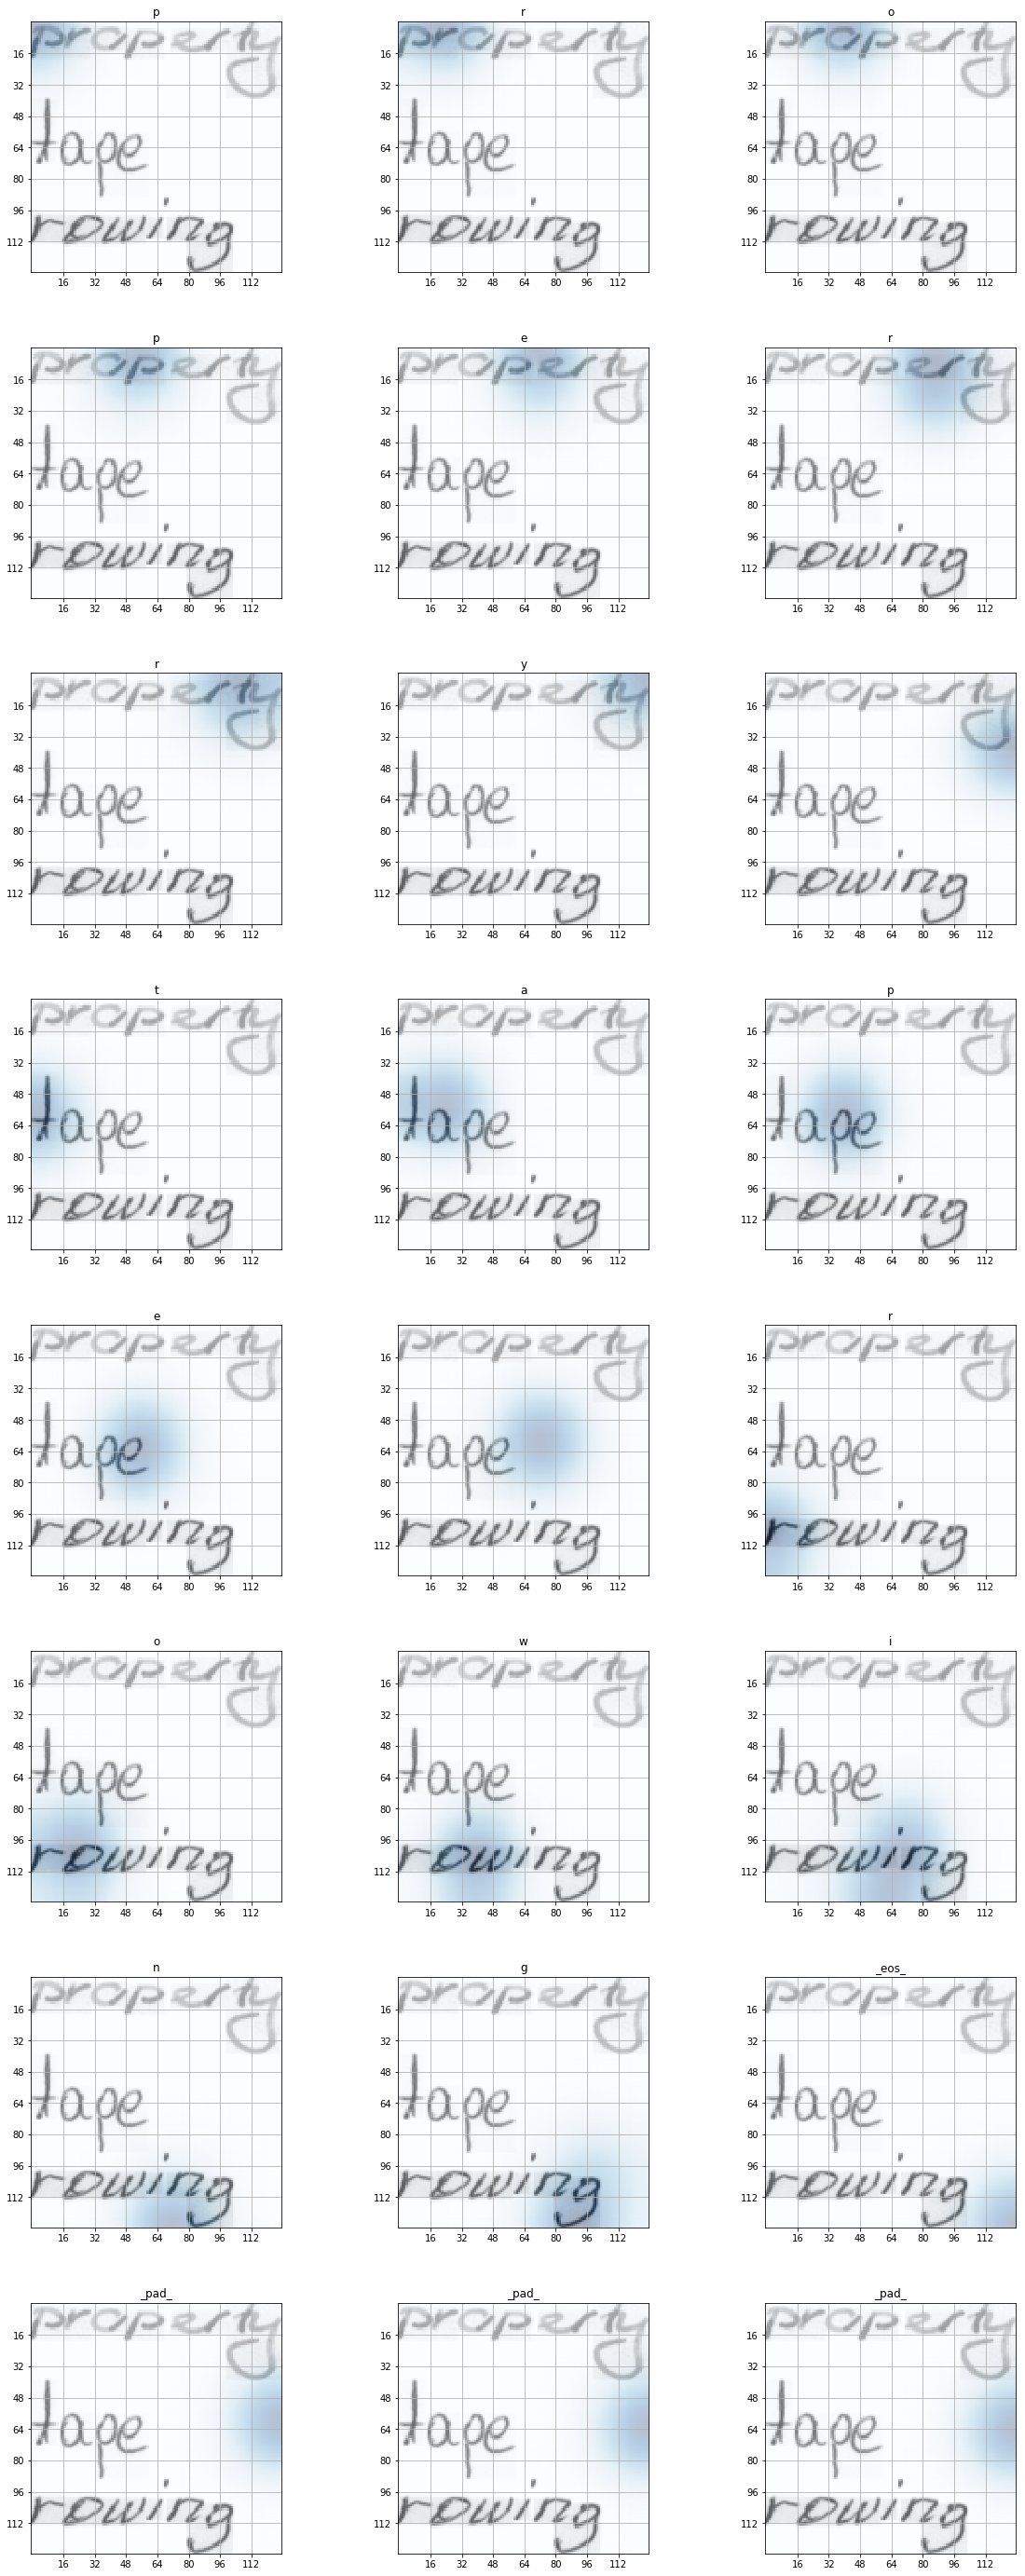

In [109]:
fig, axes = plt.subplots(8,3, gridspec_kw={'hspace': 0.3}, figsize=(20, 50))
for i,ax in enumerate(axes.flat):
    a = g_filter(img_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    
    # Attention
    ticks = np.arange(k, sz, k)
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    ax.set_title(itos[pred[i].item()])

### Target (self) Attn

Decoder Self Layer 1


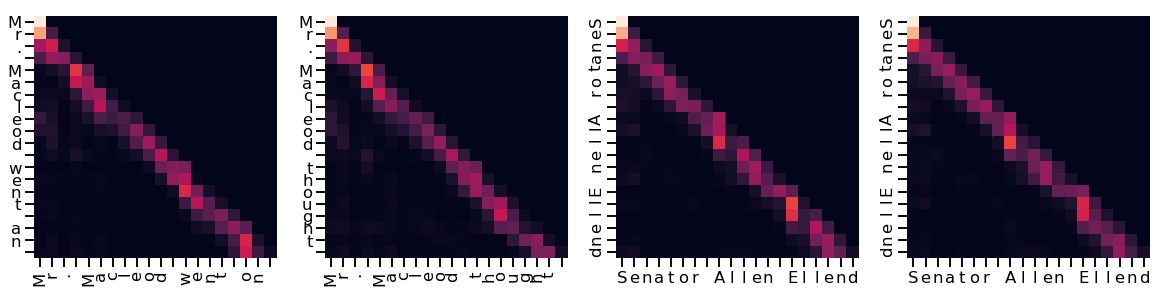

Decoder Self Layer 2


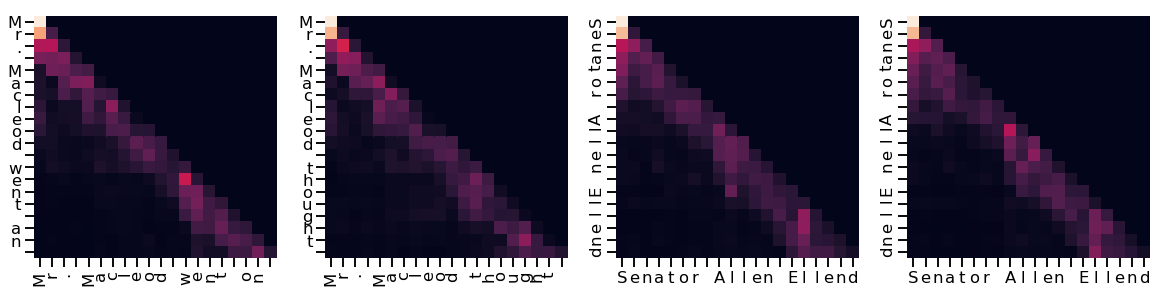

In [70]:
sns.set_context(context="talk")

def draw(data, x, y, ax):
    sns.heatmap(data, xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, cbar=False, ax=ax)

# h = 0  #attn head
for layer in range(2):
    print("Decoder Self Layer", layer+1)
    fig, axes = plt.subplots(1,4, figsize=(20, 10))
    for i,ax in enumerate(axes.flat):  # multi example
        pred = char_split_text(res[i])[:20]   # only last 20
        true = char_split_text(y[i])[:20]     # only last 20
        draw(self_attn(layer)[i].data[:len(true), :len(true)], true, pred, ax=ax)
    plt.show()

## Greedy Decode

In [45]:
x,y = next(iter(data.val_dl))
inp,targ = x,y #x[:10],y[:10]

In [46]:
learn.model.eval()
g_preds = learn.model.greedy_decode(inp, seq_len)

 69%|██████▉   | 31/45 [00:00<00:00, 94.08it/s] 


In [47]:
learn.crit(g_preds, targ)
# 3x2 256
# baseline: 9.9722
# 256+conv, pos_enc2d: 15.9952
# 512

tensor(52.0854, device='cuda:0')

In [48]:
char_error_rate(g_preds, targ)
# 3x2 256
# baseline: 0.1029
# 256+conv: 0.1174
# 512

0.2181762505083305

In [49]:
perplexity(g_preds,targ)
# 3x2 256
# baseline: 3.5850
# 256+conv: 8.2054
# 512

tensor(5.8242)

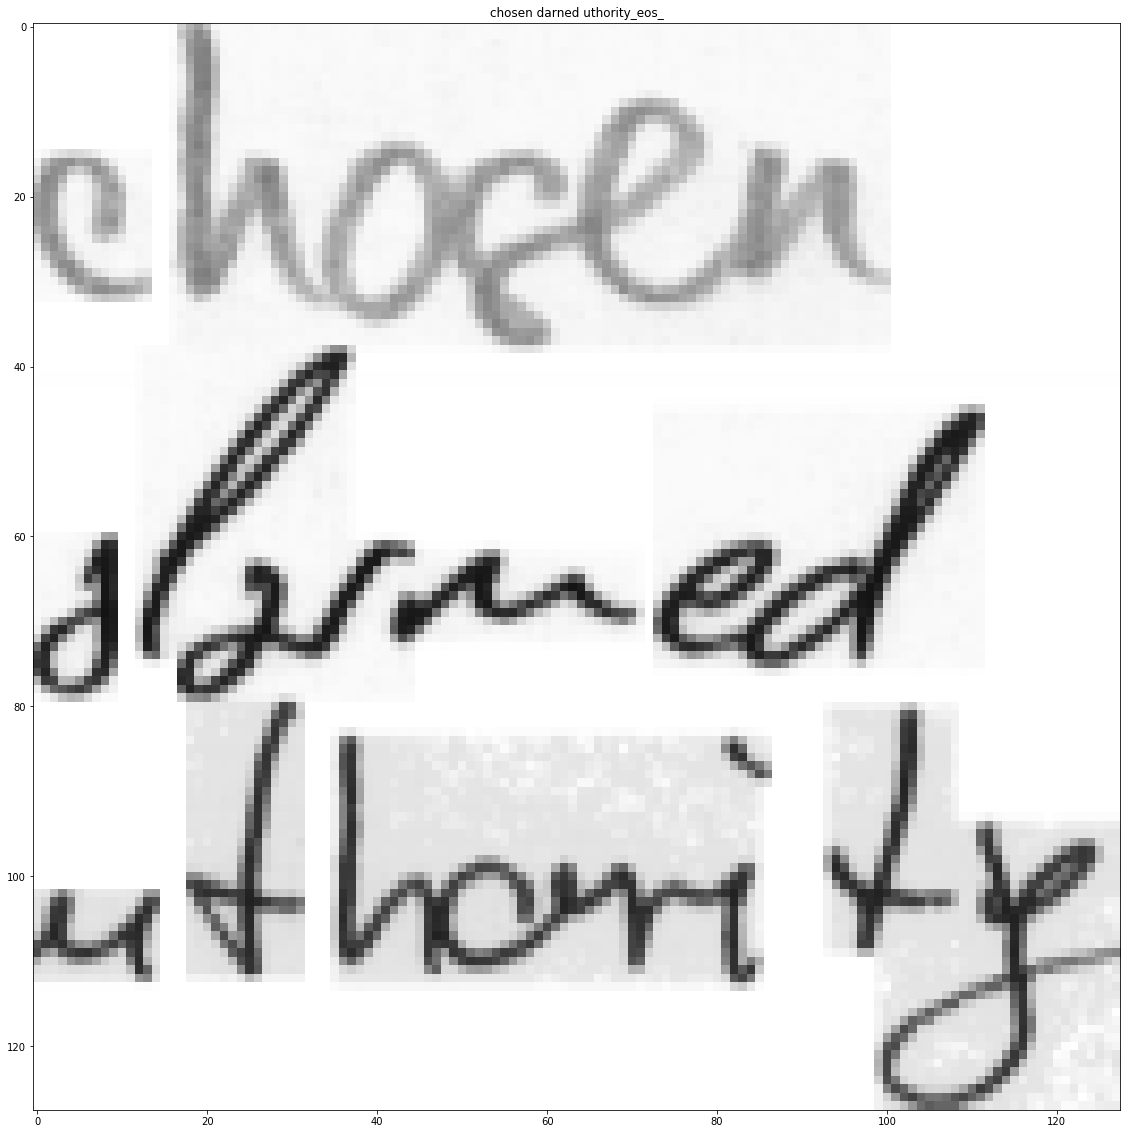

In [50]:
img = data.val_ds.denorm(inp)[0]
g_res = torch.argmax(g_preds, dim=-1)

t = char_label_text(g_res[0])
show_img(img, figsize=(20,20), title=t)

### Attention

#### 4 heads

In [74]:
# 4 heads
src_attn = source_attn()[0]  #([4, 21, 256])   # 4 attn heads
# pred = g_res[0]
img_attns = to_np(torch_scale_attns(src_attn)) # heads, sl, h, w

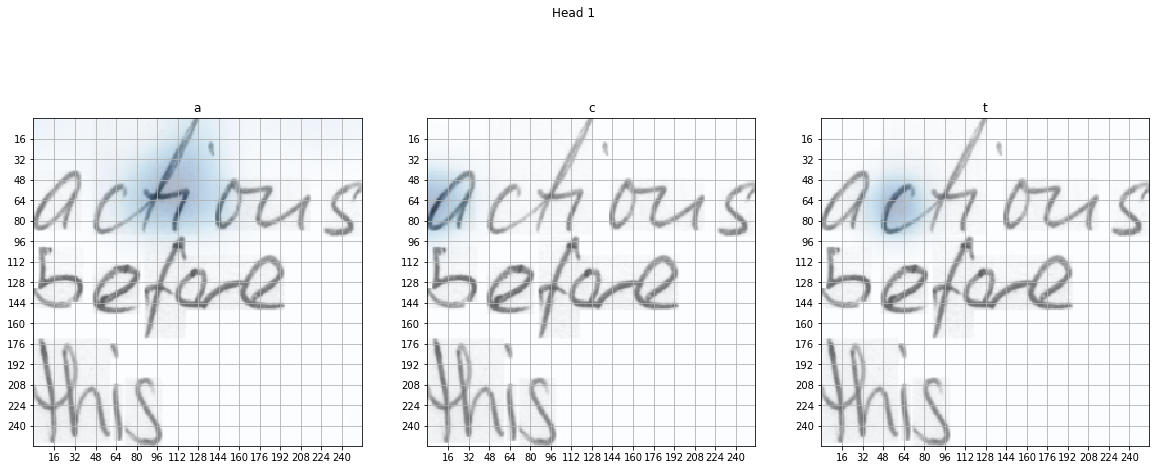

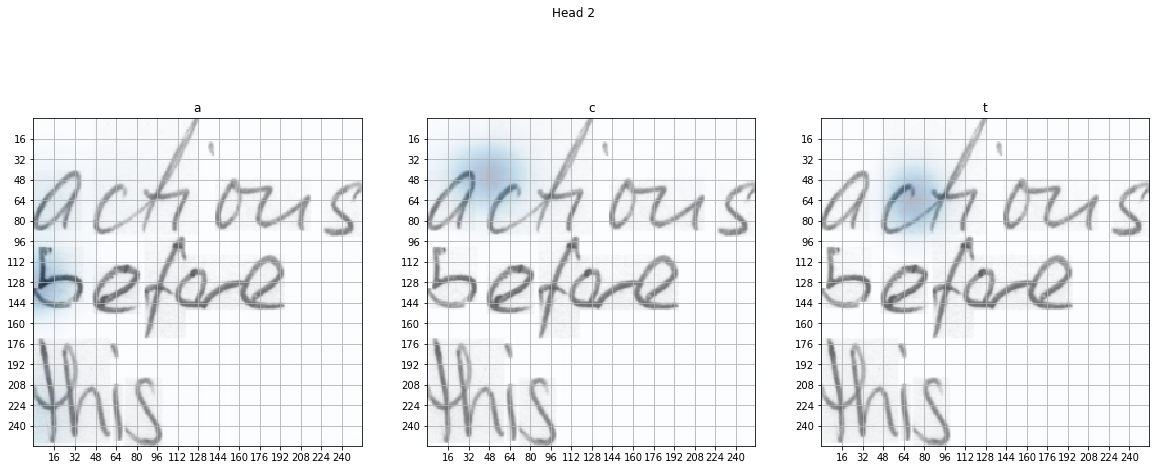

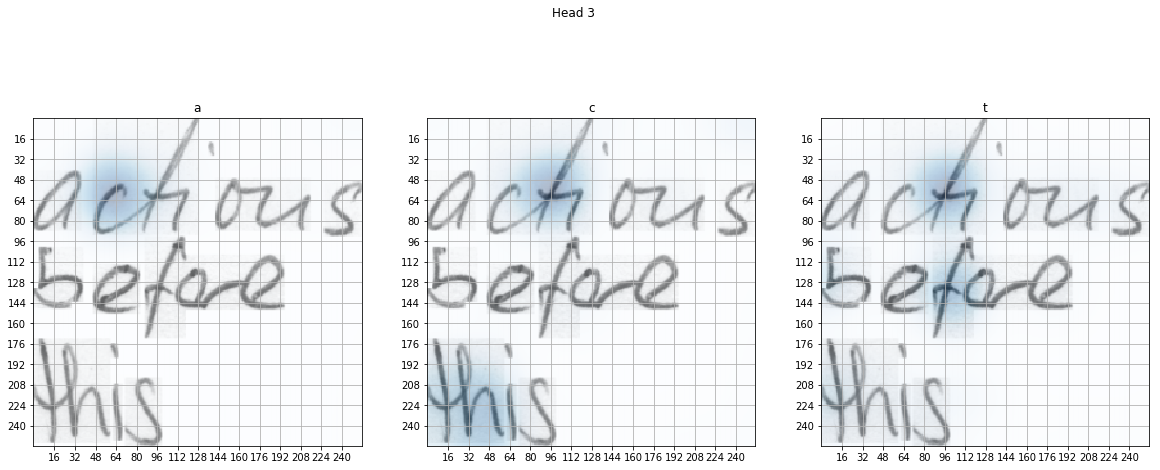

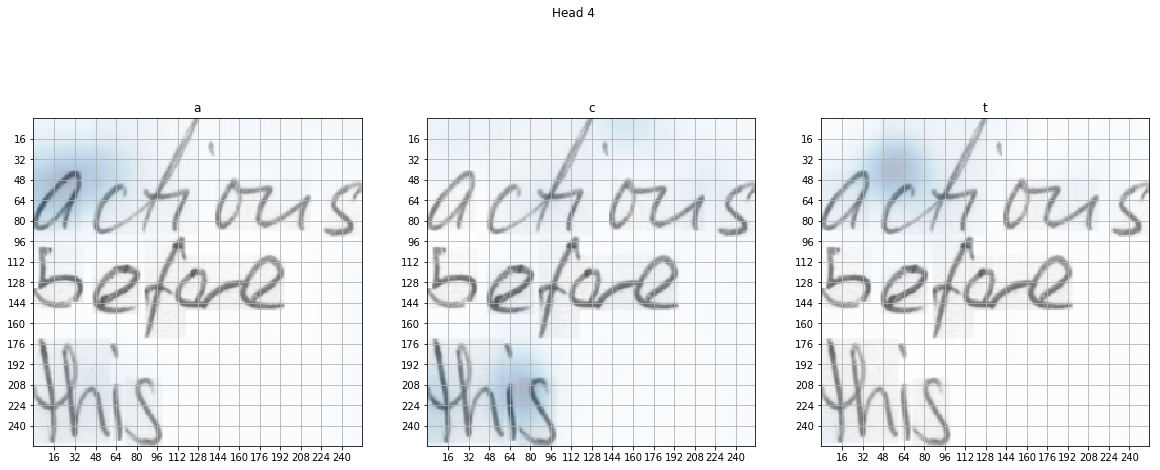

In [80]:
#attn heads (first layer)
src_attn = source_attn(0)[0]
img_attns = to_np(torch_scale_attns(src_attn)) # heads, sl, h, w

for h in range(4):
    fig, axes = plt.subplots(1,3, gridspec_kw={'hspace': 0.3}, figsize=(20, 8))
    fig.suptitle(f"Head {h+1}")
    for i,ax in enumerate(axes.flat):
        a = g_filter(img_attns[h,i])
        ax.imshow(img, alpha=None)
        ax.imshow(a, cmap='Blues', alpha=0.3)

        # Attention
        ticks = np.arange(k, sz, k)
        ax.set_yticks(ticks, minor=False)
        ax.set_xticks(ticks, minor=False)
        ax.yaxis.grid(True)
        ax.xaxis.grid(True)

        ax.set_title(itos[pred[i].item()])

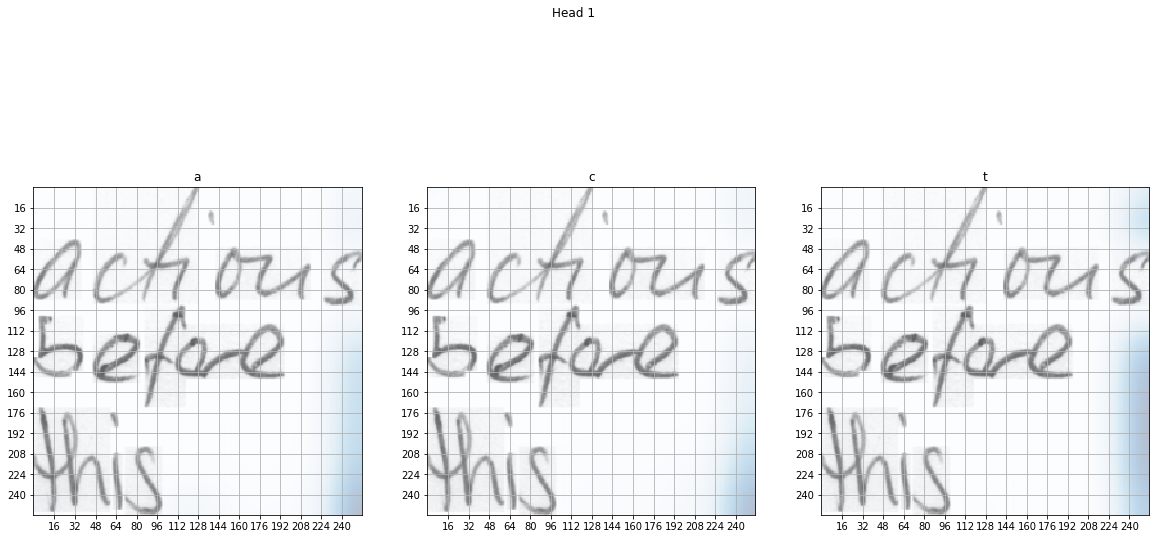

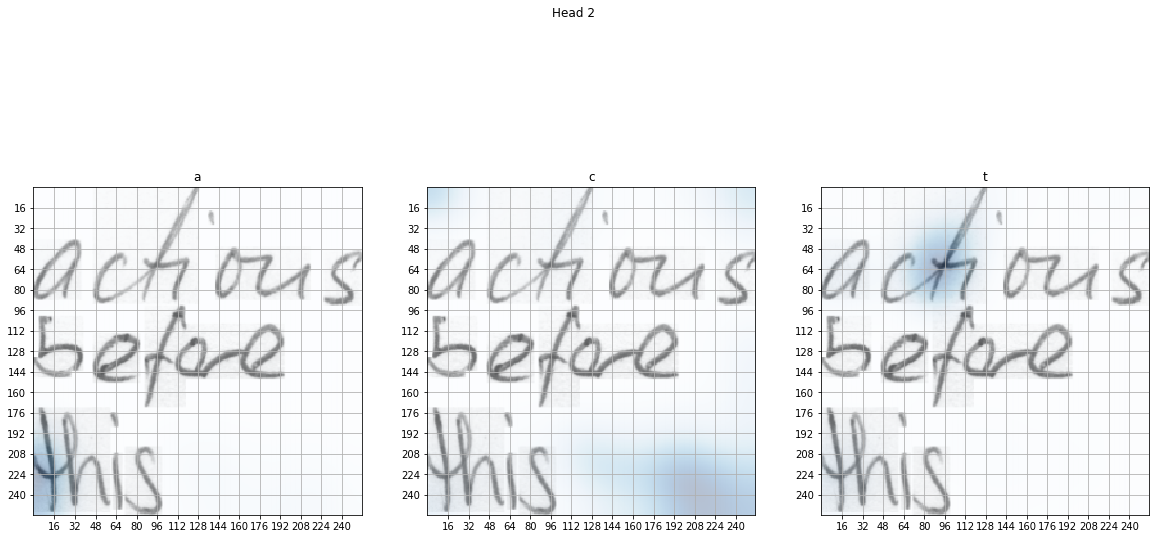

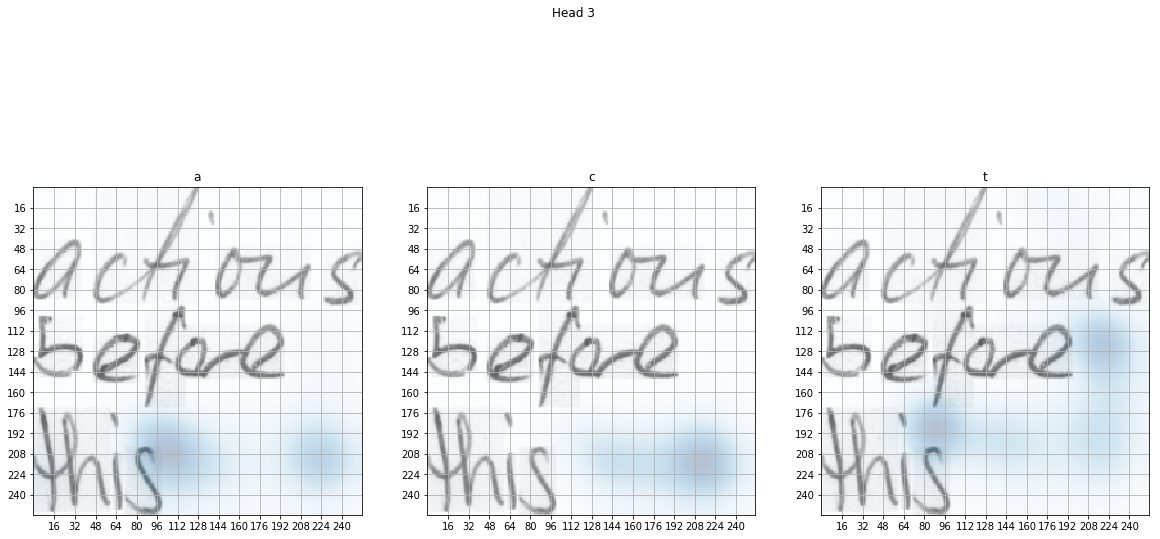

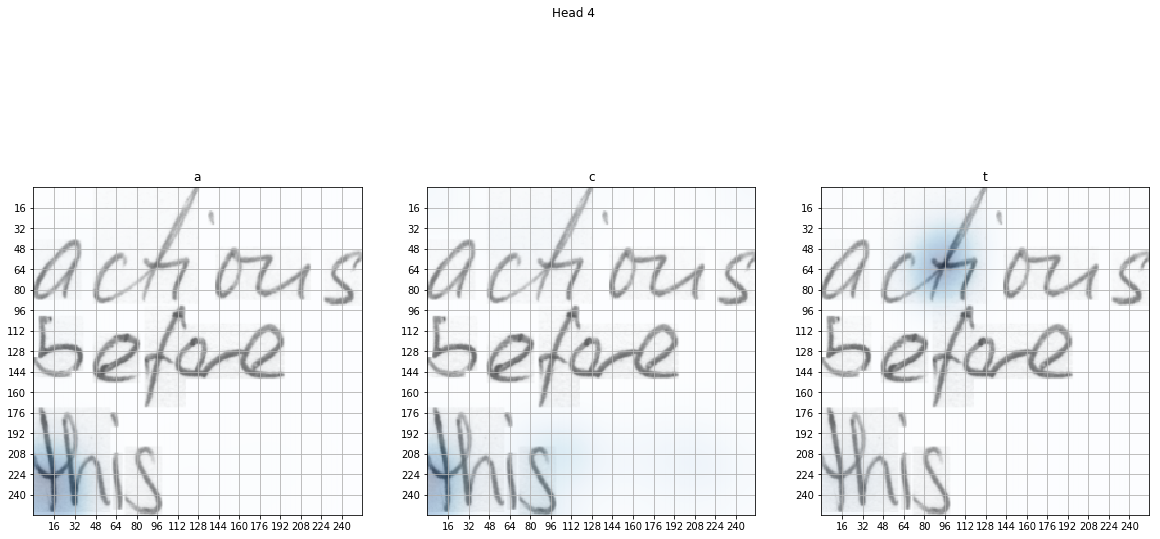

In [79]:
#attn heads (last_layer)
for h in range(4):
    fig, axes = plt.subplots(1,3, gridspec_kw={'hspace': 0.3}, figsize=(20, 10))
    fig.suptitle(f"Head {h+1}")
    for i,ax in enumerate(axes.flat):
        a = g_filter(img_attns[h,i])
        ax.imshow(img, alpha=None)
        ax.imshow(a, cmap='Blues', alpha=0.3)

        # Attention
        ticks = np.arange(k, sz, k)
        ax.set_yticks(ticks, minor=False)
        ax.set_xticks(ticks, minor=False)
        ax.yaxis.grid(True)
        ax.xaxis.grid(True)

        ax.set_title(itos[pred[i].item()])

#### single head

In [51]:
# single attn
src_attn = source_attn()  #([1, sl, h*w])
pred = g_res[0]
img_attns = to_np(torch_scale_attns(src_attn)[0]) # sl, sz, sz

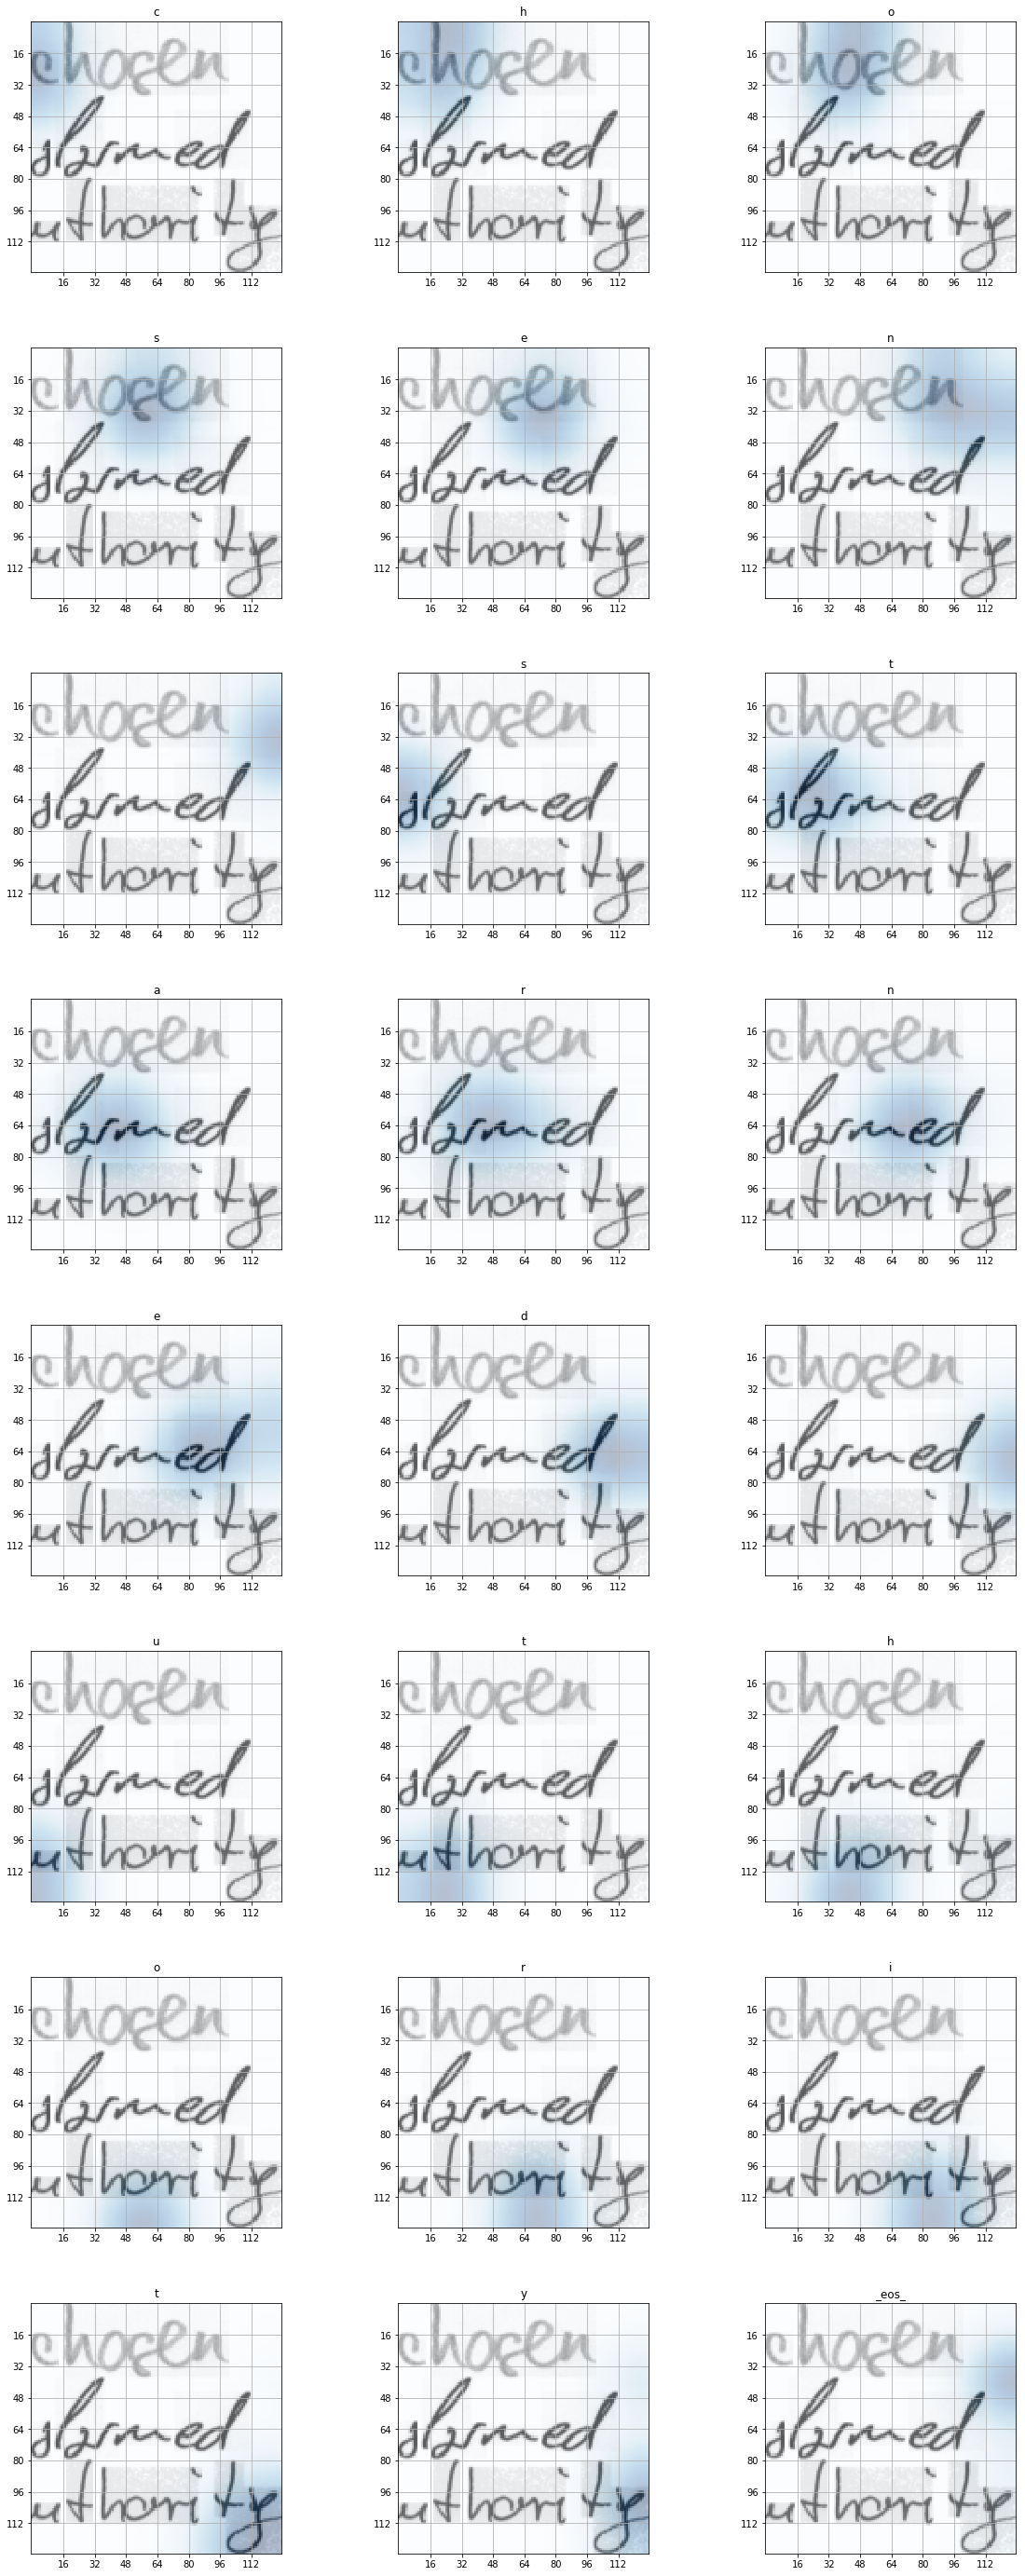

In [64]:
fig, axes = plt.subplots(8,3, gridspec_kw={'hspace': 0.3}, figsize=(20, 50))
for i,ax in enumerate(axes.flat):
    a = g_filter(img_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', alpha=0.3)

    # Attention
    ticks = np.arange(k, sz, k)
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    ax.set_title(itos[pred[i].item()])

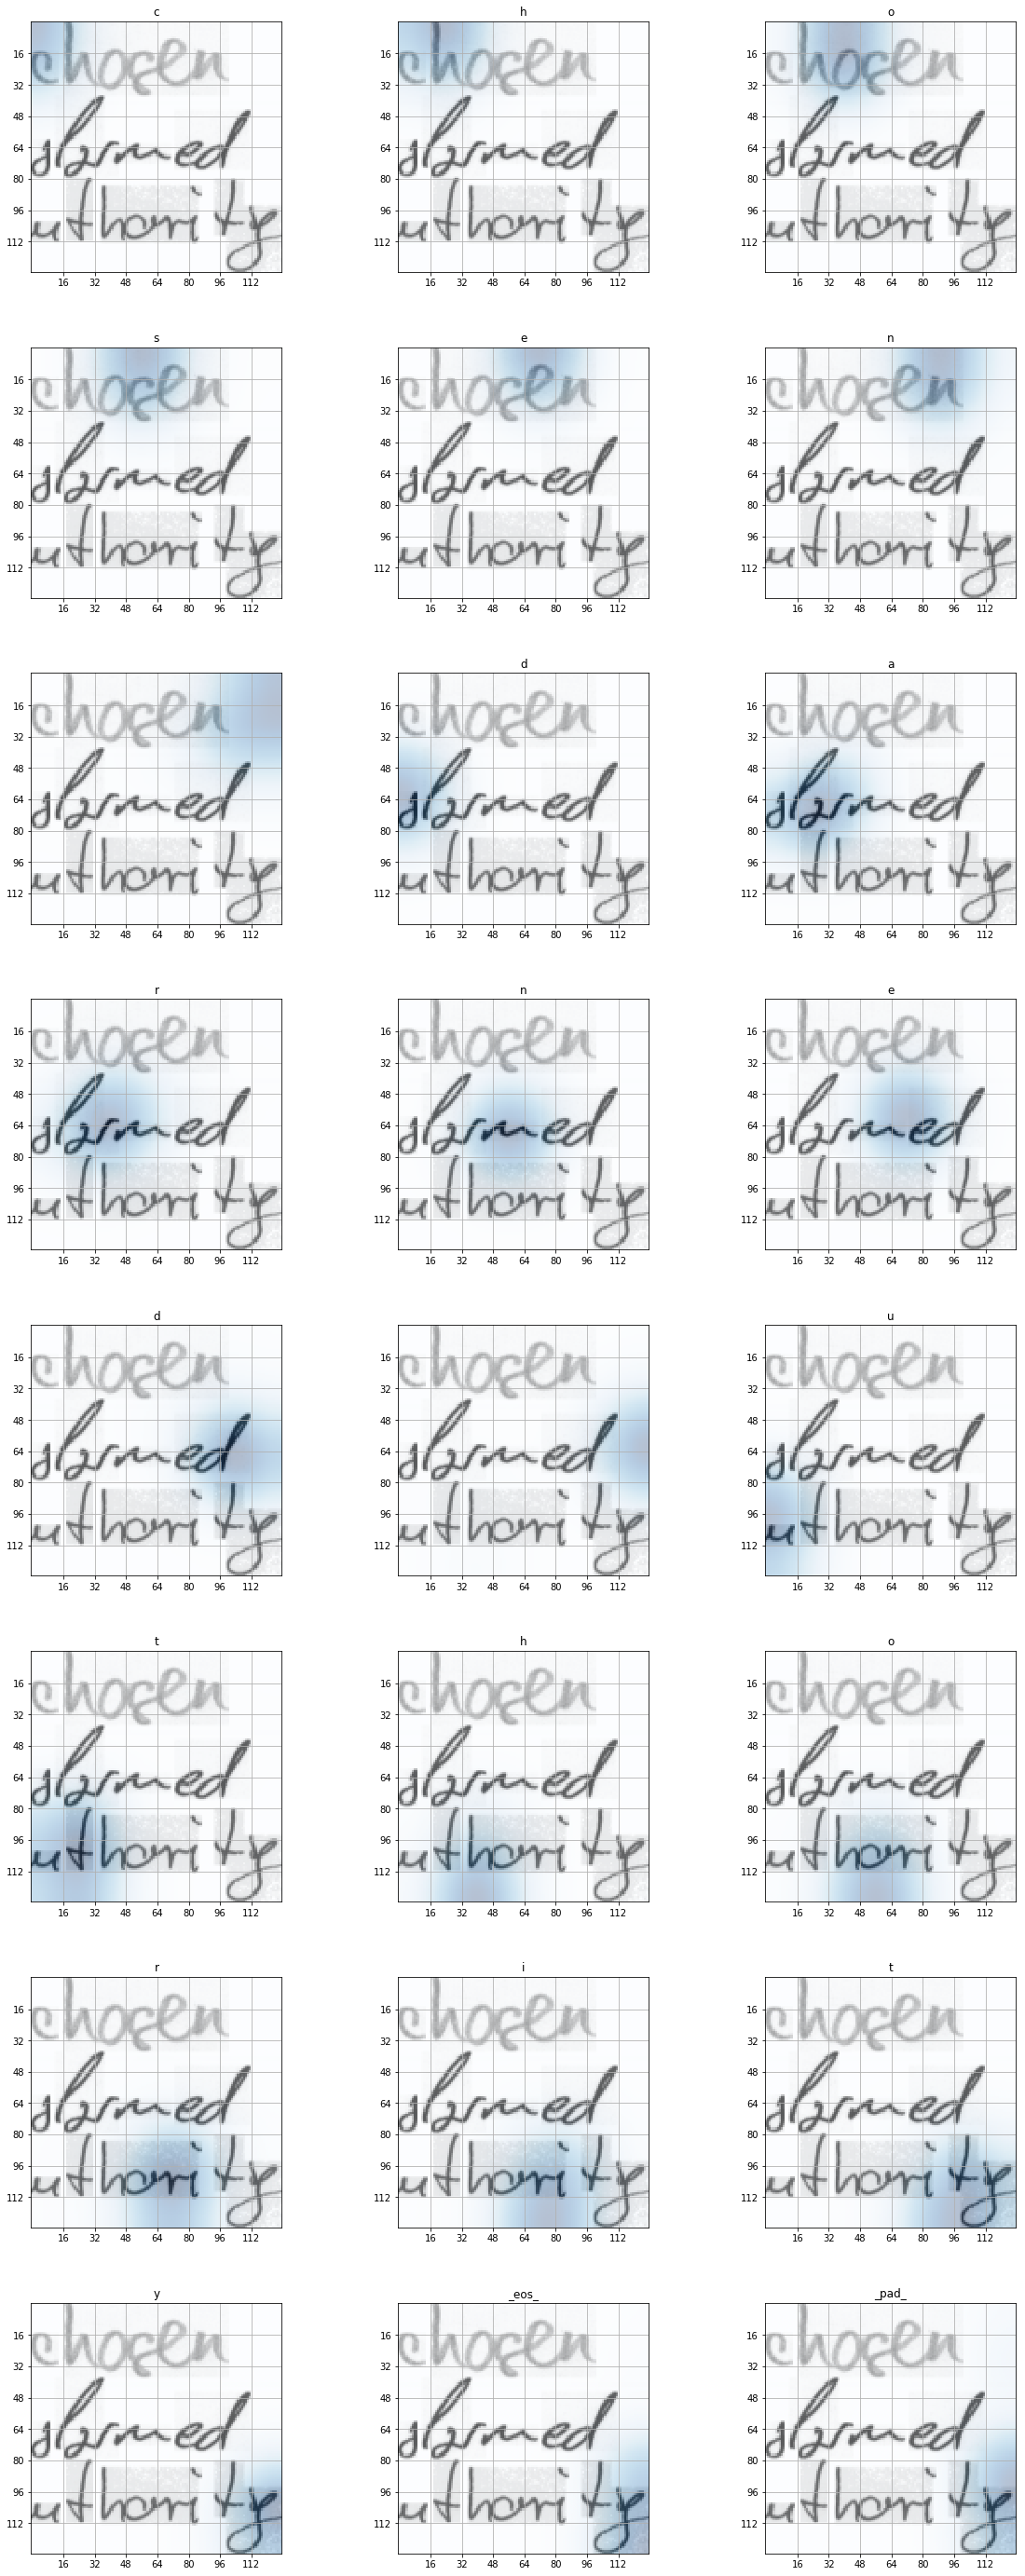

In [52]:
fig, axes = plt.subplots(8,3, gridspec_kw={'hspace': 0.3}, figsize=(20, 50))
for i,ax in enumerate(axes.flat):
    a = g_filter(img_attns[i])
#     a = img_attns[i]
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', alpha=0.3)

    # Attention
    ticks = np.arange(k, sz, k)
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    ax.set_title(itos[pred[i].item()])